## SAM (self-assembling-manifold) on HSC/MPP cells
---
##### hpb29

Date: 2021-01-18

In [1]:
%matplotlib nbagg

import warnings
warnings.filterwarnings('ignore')

import os, sys, json, operator, getpass
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import scanpy as sc

from samalg import SAM

import scanorama
import scanpy.external as sce

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
with open('/.singularity.d/labels.json') as fh:
    singularity = json.load(fh)
    
singularity['Version']

'mictlan.20f'

In [3]:
sc.settings.verbosity = 3             # show some output
sc.settings.file_format_figs = 'svg'  # set this to 'svg' (notebook) or 'pdf' (files) if you want vector graphics
sc.settings.savefigs = False

In [4]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rc('font', size=14)

In [5]:
home = str(Path.home())
user = getpass.getuser()

basedir = os.path.join(home, 'datafloor/users', user, 'EL/Nicole/2020/SLX19841/')

sc.settings.writedir = os.path.join(basedir, 'analysis/h5ad/')

seurat integrated dataset

In [6]:
data = sc.read('COMBO10_NO_SPL3_Seurat3_data_integrated')

base normalised dataset

In [8]:
reference = sc.read('COMBO10_NO_SPL3_Seurat3_lognorm')

Intersect INTEGRATED data with common cells (on downstream processed data)

In [11]:
data = data[reference.obs.index].copy()

replace obs on the seurat integrated dataset

In [16]:
data.obs = reference.obs.copy()

**Select just the deemed HSC/MPPs clusters**

In [19]:
selection = data[data.obs['leiden.1.2'].isin(['0','4','5','11','21']), :].copy()

In [20]:
selection.shape

(34882, 2000)

# HSC/MPPs from DOD1, DOD2 and DOD4

# BM and SPL

In [21]:
dods = selection[selection.obs.donor.isin(['DOD1', 'DOD2', 'DOD4']), :].copy()
# exclude PBs
dods = dods[~(dods.obs.organ == 'PB'),:].copy()

In [22]:
donor1 = dods[dods.obs.donor == 'DOD1'].copy()

donor2 = dods[dods.obs.donor == 'DOD2'].copy()

donor4 = dods[dods.obs.donor == 'DOD4'].copy()

In [23]:
%%time

corrected = scanorama.correct_scanpy([donor1, donor2, donor4])

Found 2000 genes among all datasets
[[0.         0.6765896  0.81400839]
 [0.         0.         0.78034682]
 [0.         0.         0.        ]]
Processing datasets (0, 2)
Processing datasets (1, 2)
Processing datasets (0, 1)
CPU times: user 1min 31s, sys: 5.01 s, total: 1min 36s
Wall time: 1min 36s


In [24]:
corrected[0].obs['donor'] = 'DOD1'
corrected[1].obs['donor'] = 'DOD2'
corrected[2].obs['donor'] = 'DOD4'
#corrected[3].obs['donor'] = 'DOD4'


combined = corrected[0].concatenate(corrected[1], corrected[2])

In [25]:
dods.shape

(16651, 2000)

In [26]:
combined.shape

(16651, 2000)

In [27]:
combined.obs = dods.obs.copy()

combined.var = dods.var.copy()

In [28]:
%%time
sam_dod3x_nopb = sce.tl.sam(combined, standardization=None)

Self-assembling manifold
Running SAM
`X_disp` layer contains negative values. Setting `weight_mode` to 'variance'.
RUNNING SAM
Iteration: 0, Convergence: 1.0
Recomputing means and variances.
Iteration: 1, Convergence: 0.7870414312736685
Iteration: 2, Convergence: 0.04190726855367395
Iteration: 3, Convergence: 0.01253376859356498
Iteration: 4, Convergence: 0.010105385175240823
Iteration: 5, Convergence: 0.006328997899660424
Computing the UMAP embedding...
Elapsed time: 96.53705406188965 seconds
CPU times: user 1min 31s, sys: 5.42 s, total: 1min 36s
Wall time: 1min 36s


<IPython.core.display.Javascript object>


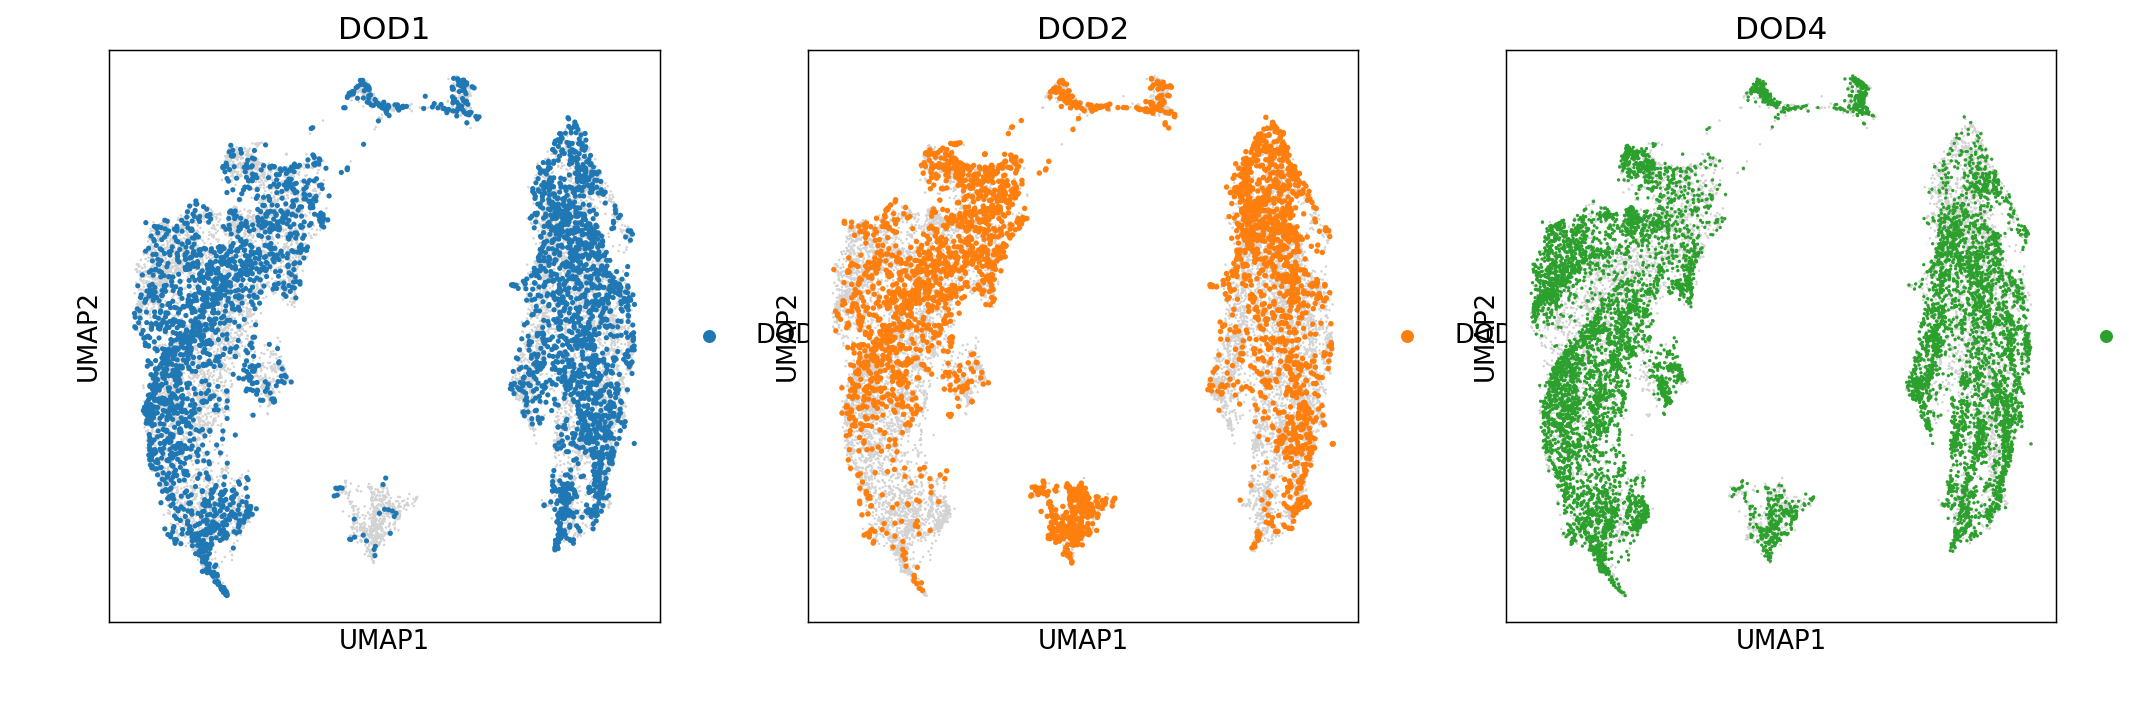

In [30]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
fig.tight_layout()
ax = ax.ravel()

sc.pl.umap(combined, ax=ax[0])
sc.pl.umap(combined[combined.obs.donor == 'DOD1', : ], color=['donor'], ax=ax[0], title='DOD1')

sc.pl.umap(combined, ax=ax[1])
sc.pl.umap(combined[combined.obs.donor == 'DOD2', : ], color=['donor'], ax=ax[1], title='DOD2')

sc.pl.umap(combined, ax=ax[2])
sc.pl.umap(combined[combined.obs.donor == 'DOD4', : ], color=['donor'], ax=ax[2], title='DOD4')

In [32]:
X_umap = combined.obsm['X_umap']

In [33]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_umap)
combined.obs['kmeans2'] = kmeans.labels_.astype(str)

kmeans = KMeans(n_clusters=4, random_state=0).fit(X_umap)
combined.obs['kmeans4'] = kmeans.labels_.astype(str)

<IPython.core.display.Javascript object>


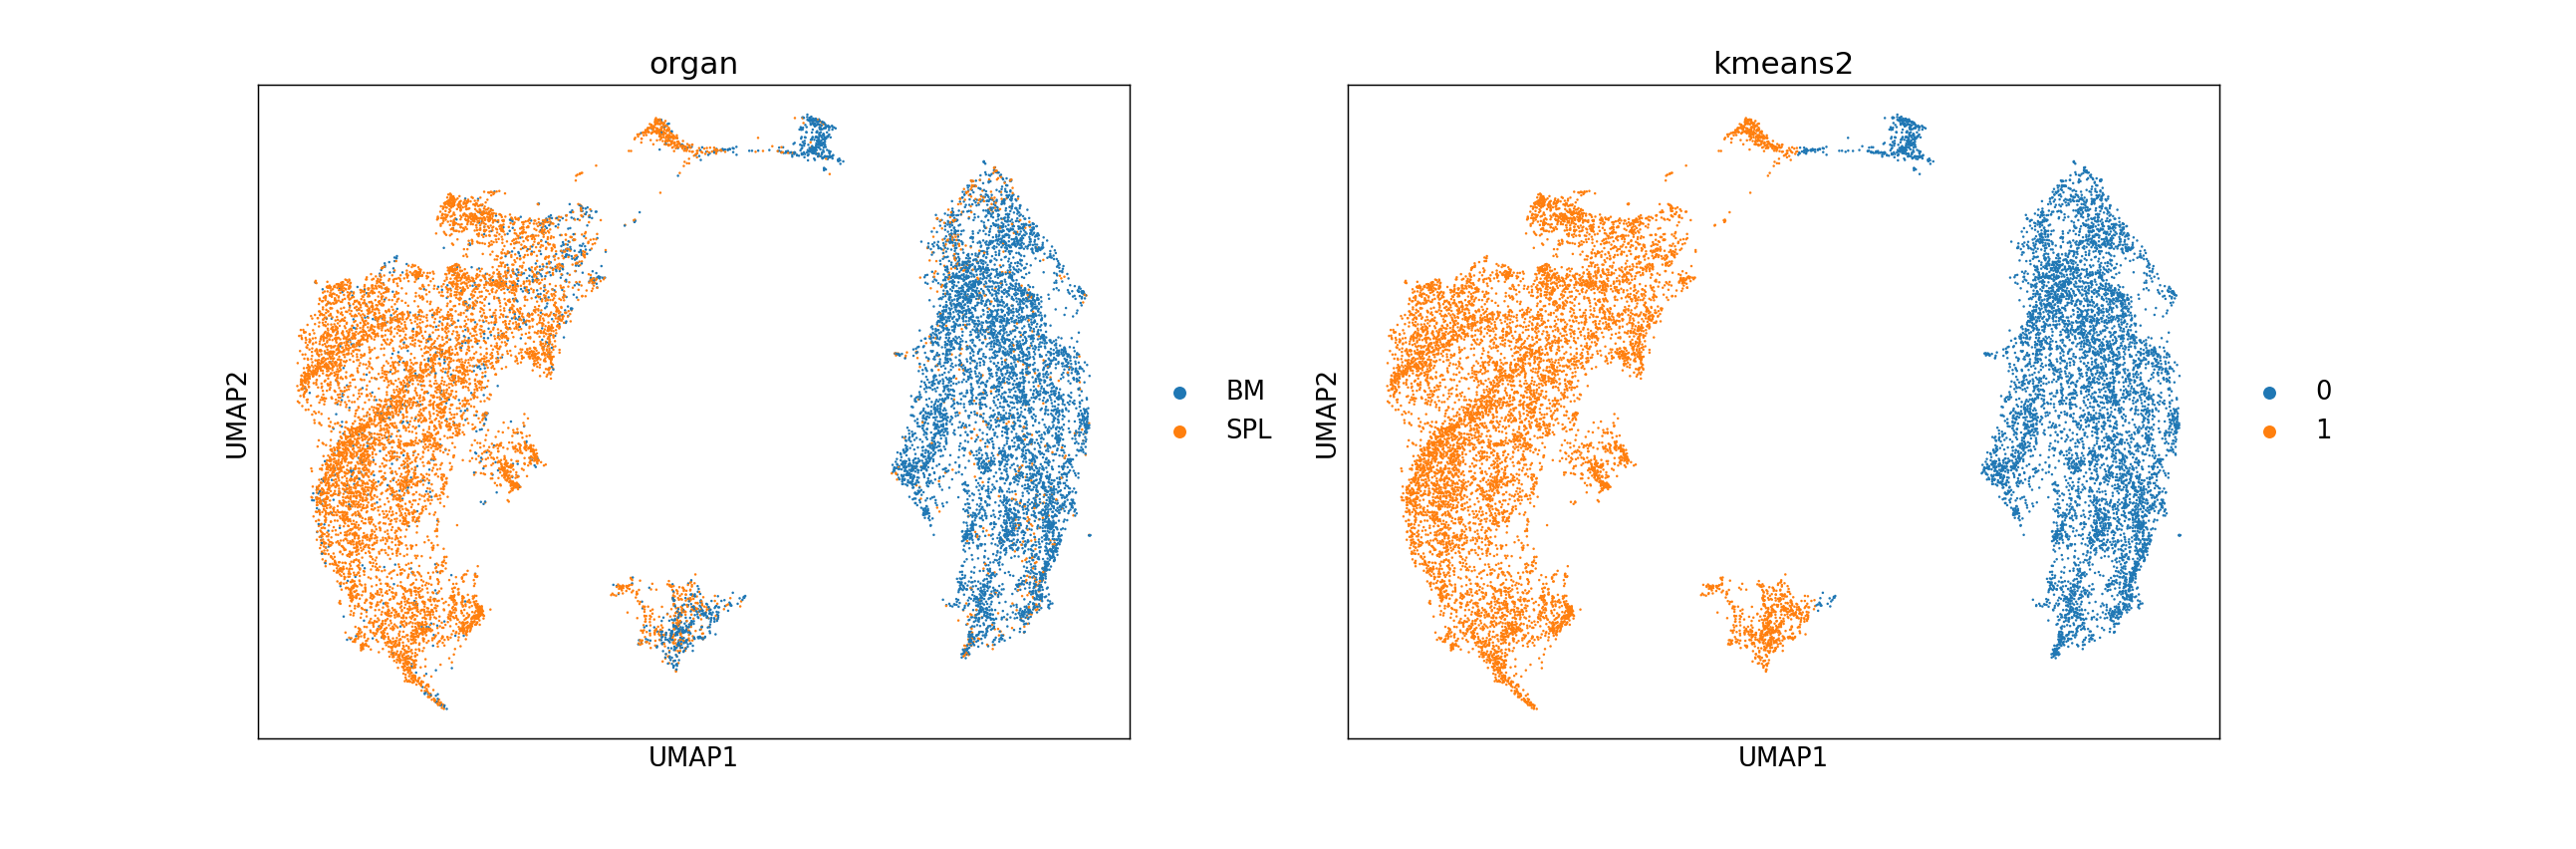

In [35]:
sc.pl.umap(combined, color=['organ', 'kmeans2'])

In [36]:
%%time
sc.write('COMBO10_DODx3_BM_SPL_scanorama_corrected_SAM_S3int', combined)

CPU times: user 12.9 s, sys: 544 ms, total: 13.5 s
Wall time: 14.4 s


In [39]:
a = combined[combined.obs['kmeans2']== '0' , :].obs.groupby(['donor', 'organ']).count()['batch']
b = combined[combined.obs['kmeans2']== '1' , :].obs.groupby(['donor', 'organ']).count()['batch']

In [41]:
c = pd.concat([a, b], axis=1)
c.columns = ['0', '1']

In [42]:
c

0     1
donor organ            
DOD1  BM     1546   265
      SPL     312  1689
DOD2  BM     1256   609
      SPL     196  1399
DOD4  BM     3691   295
      SPL      67  5326